Importing dependencies

In [96]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.model_selection import train_test_split

from pathlib import Path
import os
import pandas as pd

# Metrics
from sklearn.metrics import classification_report, confusion_matrix

checking the data

In [97]:
base_dir = r"/content/drive/MyDrive/Keras,Pytorch,Tensorflow/Project works/data/chart trend dataset"

image_size = (224, 224)
batch_size = 32

data_gen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

In [98]:
def convert_path_to_df(dataset):
    image_dir = Path(dataset)

    # Get filepaths and labels
    filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.jpeg')) + list(image_dir.glob(r'**/*.PNG'))
    labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

    filepaths = pd.Series(filepaths, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    image_df = pd.concat([filepaths, labels], axis=1)
    return image_df

image_df = convert_path_to_df(base_dir)
len(image_df)

928

In [99]:
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42)

In [100]:
train_gen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.15
)

test_gen = ImageDataGenerator(
    rescale=1./255
)

In [101]:
train_data = train_gen.flow_from_dataframe(
    train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=image_size,
    batch_size=batch_size,
    subset='training',
    class_mode='categorical',
    shuffle=True,
    seed=42
)


val_data = train_gen.flow_from_dataframe(
    train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=image_size,
    batch_size=batch_size,
    subset='validation',
    class_mode='categorical',
    shuffle=True,
    seed=42
)

test_data = test_gen.flow_from_dataframe(
    test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=image_size,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False
)

Found 631 validated image filenames belonging to 2 classes.
Found 111 validated image filenames belonging to 2 classes.
Found 186 validated image filenames belonging to 2 classes.


In [102]:
model = Sequential([
    Input(shape=(224,224,3)),

    Conv2D(32,(3,3),activation='relu'),
    MaxPooling2D((2,2),strides=(2,2)),

    Conv2D(64,(3,3),activation='relu'),
    MaxPooling2D((2,2),strides=(2,2)),

    Flatten(),
    Dense(256,activation='relu'),
    Dense(2,activation='softmax')
])

In [103]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [104]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)                   │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 186624)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 256)                 │      47,776,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 47,795,906 (182.33 MB)

 Trainable params: 47,795,906 (182.33 MB)

 Non-trainable params: 0 (0.00 B)

In [105]:
history = model.fit(
    train_data,
    steps_per_epoch = train_data.samples // batch_size,
    epochs = 7,
    validation_data = val_data,
    validation_steps = val_data.samples // batch_size
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/7
19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 252ms/step - accuracy: 0.5041 - loss: 15.0091 - val_accuracy: 0.6354 - val_loss: 0.5682
Epoch 2/7
 1/19 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.7812 - loss: 0.5361

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.7812 - loss: 0.5361 - val_accuracy: 0.7708 - val_loss: 0.5187
Epoch 3/7
19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 443ms/step - accuracy: 0.8999 - loss: 0.3658 - val_accuracy: 0.9271 - val_loss: 0.1559
Epoch 4/7
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 1.0000 - loss: 0.1048 - val_accuracy: 0.9583 - val_loss: 0.1295
Epoch 5/7
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 189ms/step - accuracy: 0.9869 - loss: 0.0738 - val_accuracy: 0.9896 - val_loss: 0.0153
Epoch 6/7
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 1.0000 - loss: 0.0019 - val_accuracy: 0.9896 - val_loss: 0.0184
Epoch 7/7
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 264ms/step - accuracy: 1.0000 - loss: 0.0091 - val_accuracy: 1.0000 - val_loss: 0.0040


In [106]:
val_loss,val_acc = model.evaluate(val_data,steps= val_data.samples // batch_size)

print(f"Validation accuracy: {round(val_acc, 4)*100}%")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 1.0000 - loss: 0.0041
Validation accuracy: 100.0%


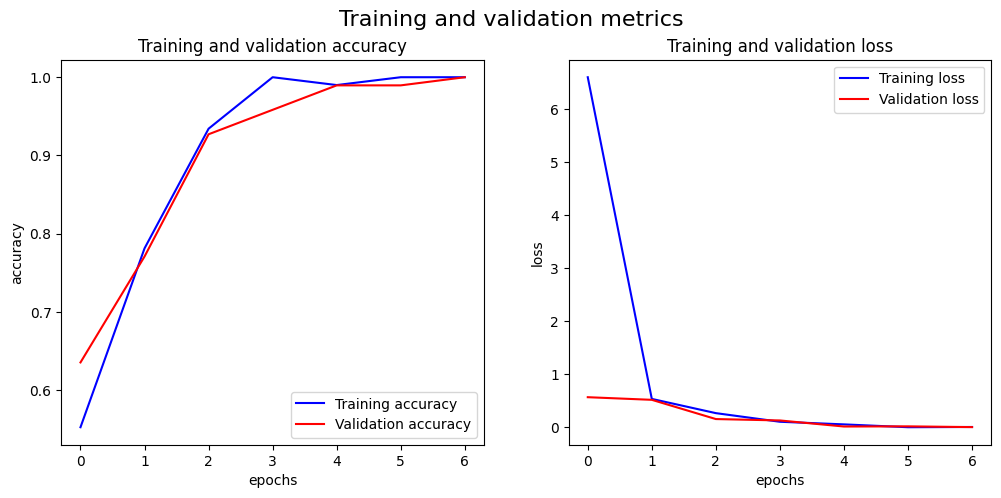

In [107]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 5))

ax1.plot(epochs, accuracy, 'b', label='Training accuracy')
ax1.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
ax1.set_title('Training and validation accuracy')
ax1.set_xlabel('epochs')
ax1.set_ylabel('accuracy')
ax1.legend()

ax2.plot(epochs, loss, 'b', label='Training loss')
ax2.plot(epochs, val_loss, 'r', label='Validation loss')
ax2.set_title('Training and validation loss')
ax2.set_xlabel('epochs')
ax2.set_ylabel('loss')
ax2.legend()

fig.suptitle('Training and validation metrics', fontsize=16)
plt.show()

In [108]:
pred = model.predict(test_data)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_data.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 168ms/step
The first 5 predictions: ['uptrend', 'uptrend', 'downtrend', 'downtrend', 'downtrend']


In [112]:
y_test = list(test_df.Label)
report = classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df

,precision,recall,f1-score,support
downtrend,0.988636,0.988636,0.988636,88.000000
uptrend,0.989796,0.989796,0.989796,98.000000
accuracy,0.989247,0.989247,0.989247,0.989247
macro avg,0.989216,0.989216,0.989216,186.000000
weighted avg,0.989247,0.989247,0.989247,186.000000


In [113]:
model.save("chart_trend_model.keras")